In [1]:
import numpy as np
import pandas as pd

freq_item = pd.read_csv('../arm/freqitem2.csv')
freq_item = freq_item[freq_item['count'] >= 100]
items = freq_item['items']

<AxesSubplot:>

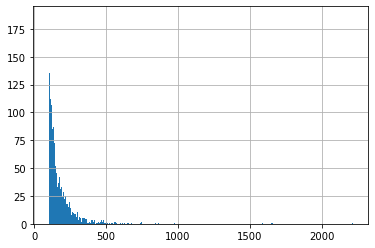

In [2]:
freq_item['count'].hist(bins=500)

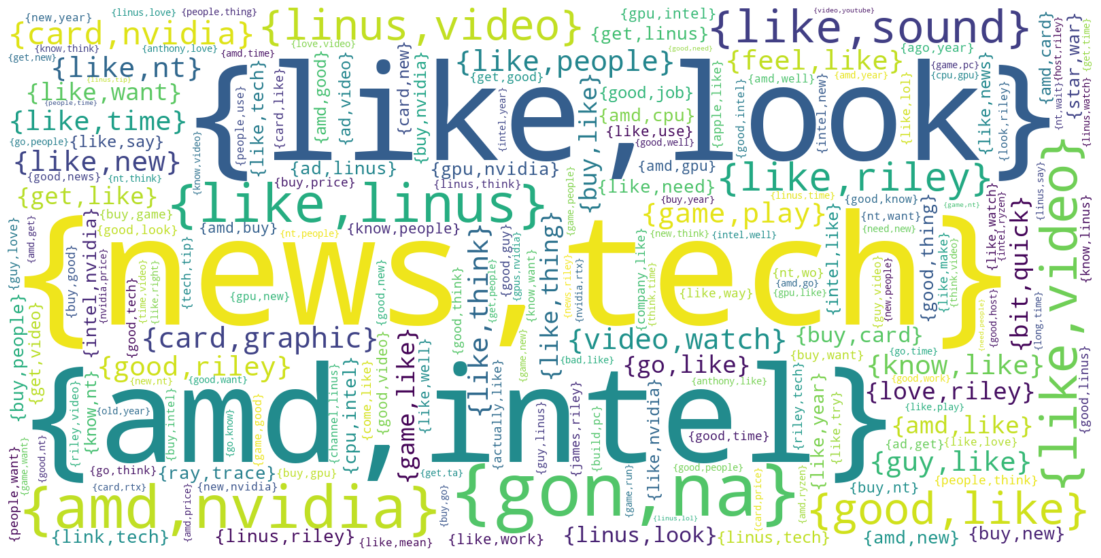

In [3]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

freq = {k:v for k, v in zip(freq_item['items'], freq_item['count'])}
wc = WordCloud(background_color="white", height=800, width=1600).generate_from_frequencies(freq)
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig(f'wordcloud.png', dpi=300, bbox_inches='tight')

In [4]:
feat = [it[1:-1].split(',') for it in items]

In [5]:
comment = pd.read_csv('../data/comments_labeled.csv')
labeled = comment[comment['LABEL'] > 0]
labeled.reset_index(inplace=True)

In [6]:
from collections import Counter
from tqdm import tqdm

comment_arr = np.zeros(shape=(len(labeled),len(feat)), dtype=np.int8)
for i, row in tqdm(labeled.iterrows()):
    text = Counter(row['text'].split())
    for j, item in enumerate(feat):
        if item[0] in text and item[1] in text:
            comment_arr[i][j] = min(text[item[0]], text[item[1]])

44648it [00:14, 2978.06it/s]


In [7]:
comment_arr.tofile('comment_arm.binary')

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

y_train = labeled['LABEL']

cls1 = DecisionTreeClassifier(criterion='gini', max_depth=35, min_samples_split=10, random_state=0)
cls1.fit(comment_arr, y_train)
y_pred1 = cls1.predict(comment_arr)
print(accuracy_score(y_train, y_pred1))
print(f1_score(y_train, y_pred1, average=None))
print(confusion_matrix(y_train, y_pred1))

0.5884250134384519
[0.40835267 0.46292327 0.22367195 0.13604577 0.70090172]
[[ 2200     0     0     0  6375]
 [    0  1620     0     0  3759]
 [    0     0   600     0  4165]
 [    0     0     0   321  4077]
 [    0     0     0     0 21531]]


In [9]:
import pydotplus
from sklearn.tree import export_graphviz

label_names = {
    0: 'None',
    1: 'GPU',
    2: 'CPU',
    3: 'Phone',
    4: 'TechCompany',
    5: 'Channel',
    -1: 'MoreThanOneClass'
}

def draw_model(tree, filename):
    dot_data = export_graphviz(tree,
    out_file = None,
	feature_names = [x for x in items],
	class_names = [label_names[x] for x in tree.classes_],
	filled=True,
	rounded = True,
	special_characters = True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_png(filename)

draw_model(cls1, 'cls_arm.png')

In [10]:
df_show = pd.DataFrame(comment_arr, columns=[x for x in items])

In [11]:
from sklearn.ensemble import RandomForestClassifier

cls_full = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=35, max_features=50, max_samples=1000, min_samples_split=10, n_jobs=-1, random_state=0)
cls_full.fit(comment_arr, y_train)
y_pred_full = cls_full.predict(comment_arr)
print(accuracy_score(y_train, y_pred_full))
print(f1_score(y_train, y_pred_full, average=None))
print(confusion_matrix(y_train, y_pred_full))

0.586543630173804
[0.41309777 0.4911641  0.1961007  0.06893524 0.6999366 ]
[[ 2233     0     0     0  6342]
 [    0  1751     0     0  3628]
 [    0     0   518     0  4247]
 [    1     0     0   157  4240]
 [    2     0     0     0 21529]]


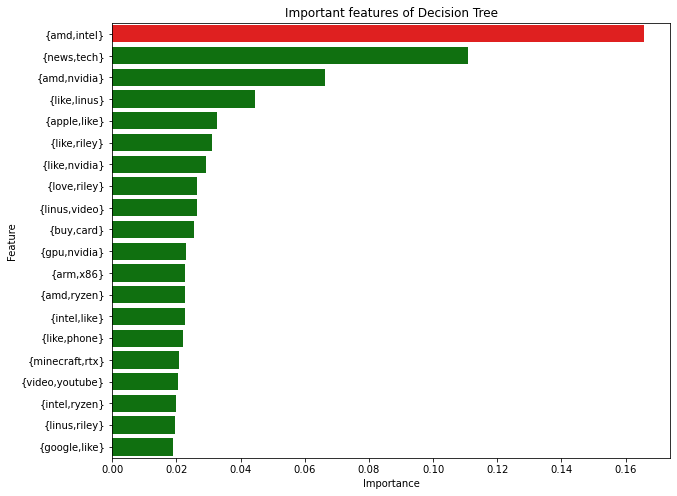

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_dict= {}
for col, val in sorted(zip([x for x in items], cls1.feature_importances_),key=lambda x:x[1],reverse=True)[:20]:
  feat_dict[col]=val
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
values = feat_df.Importance
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features of Decision Tree')
plt.savefig('df_fi.png')

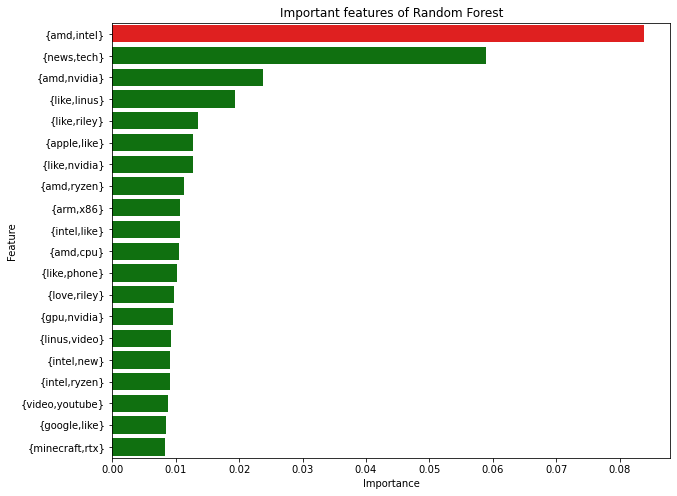

In [16]:

feat_dict= {}
for col, val in sorted(zip([x for x in items], cls_full.feature_importances_),key=lambda x:x[1],reverse=True)[:20]:
  feat_dict[col]=val
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
values = feat_df.Importance
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features of Random Forest')
plt.savefig('rf_fi.png')